## Bibliotecas/Caminhos/Banco/Funcoes

In [3]:
import os
import sys
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer


sys.path.append('../src')
from evapo_bibli                  import *

MAIN_PATH = os.path.dirname(os.path.abspath(''))
DATA_PATH = os.path.join(MAIN_PATH, 'data')
CLIMA_PATH = os.path.join(DATA_PATH, '01_raw')
DB_PATH = os.path.join(DATA_PATH, '02_intermediate')

NOTE_PATH = os.path.join(MAIN_PATH, 'notebooks')
CODE_PATH = os.path.join(MAIN_PATH, 'src')

In [4]:
import sqlite3
import pandas as pd

db = os.path.join(DB_PATH, 'clima.db')

con = sqlite3.connect(db)

df = pd.read_sql_query("SELECT * FROM tb_sudeste WHERE data > '2010/12/31' AND UF = 'SP' ", con)

In [22]:
df.to_parquet('clima_sp_2011_2020.parquet')

In [5]:
# Função para converter hora para datetime
def converter_hora(hora_str):
    try:
        # Tenta converter para o formato '0000 UTC'
        return pd.to_datetime(hora_str, format='%H%M UTC')
    except ValueError:
        # Se não for possível converter para o formato '0000 UTC', tenta converter para o formato '00:00'
        return pd.to_datetime(hora_str, format='%H:%M')
    
# Função para converter data para datetime
def converter_data(data_str):
    try:
        return pd.to_datetime(data_str, format='%Y/%m/%d')
    except ValueError:
        return pd.to_datetime(data_str, format='%Y-%m-%d')

def determinar_estacao(dia, mes):
    if (mes == 12 and dia >= 22) or (mes == 1) or (mes == 2) or (mes == 3 and dia <= 20):
        return 'Verão'
    elif (mes == 3 and dia > 20) or (mes == 4) or (mes == 5) or (mes == 6 and dia < 21):
        return 'Outono'
    elif (mes == 6 and dia >= 21) or (mes == 7) or (mes == 8) or (mes == 9 and dia < 23):
        return 'Inverno'
    elif (mes == 9 and dia >= 23) or (mes == 10) or (mes == 11) or (mes == 12 and dia < 22):
        return 'Primavera'
    else:
        return 'Data inválida'
    
    
def ml_error(model_name, y, yhat):
    """Cria um dataframe que traz as metricas MAE, MAPE, RMSE e R2 do modelo treinado

    Args:
        model_name (string): Nome do modelo
        y (_type_): Variavel target 
        yhat (_type_): Variavel target predita

    Returns:
        DataFrame: Dataframe com as métricas de desempenho do modelo
    """
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y,yhat)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE':rmse,
                         'R2': r2}, index=[0])

## Tratamento e transformação dos dados

In [6]:
aux = df[df['ESTAÇÃO'] == 'DRACENA'].copy()

aux['hora'] = aux['hora'].apply(converter_hora)
aux['data'] = aux['data'].apply(converter_data)

aux['data_hora'] = aux['data'] + pd.to_timedelta(aux['hora'].dt.hour, unit='h') + pd.to_timedelta(aux['hora'].dt.minute, unit='m')

aux.drop(columns=['hora', 'data'], inplace=True)
aux.rename(columns={'data_hora': 'data'}, inplace=True)

aux['dia'] = aux['data'].dt.day
aux['mes'] = aux['data'].dt.month
aux['ano'] = aux['data'].dt.year

aux['temperatura_max'] = aux['temperatura_max'].str.replace(',', '.').astype(float)
aux['temperatura_min'] = aux['temperatura_min'].str.replace(',', '.').astype(float)
aux['vento_velocidade'] = aux['vento_velocidade'].str.replace(',', '.').astype(float)
aux['radiacao_global'] = aux['radiacao_global'].str.replace(',', '.').astype(float)
aux['ALTITUDE'] = aux['ALTITUDE'].str.replace(',', '.').astype(float)
aux['LATITUDE'] = aux['LATITUDE'].str.replace(',', '.').astype(float)
aux['precipitacao_total'] = aux['precipitacao_total'].str.replace(',', '.').astype(float)

aux2 = aux.copy()

aux2['temperatura_min'] = aux2['temperatura_min'].replace(0, np.nan)
aux2['temperatura_min'] = aux2['temperatura_min'].mask(aux2['temperatura_min'] < 0)
aux2['temperatura_max'] = aux2['temperatura_max'].replace(0, np.nan)
aux2['temperatura_max'] = aux2['temperatura_max'].mask(aux2['temperatura_max'] < 0)
aux2['umidade_rel'] = aux2['umidade_rel'].mask(aux2['umidade_rel'] < 0)
aux2['radiacao_global'] = aux2['radiacao_global'].replace(0, np.nan)
aux2['radiacao_global'] = aux2['radiacao_global'].mask(aux2['radiacao_global'] < 0)
aux2['vento_velocidade'] = aux2['vento_velocidade'].mask(aux2['vento_velocidade'] < 0)
aux2['precipitacao_total'] = aux2['precipitacao_total'].mask(aux2['precipitacao_total'] < 0)

aux2['temperatura_max'] = aux2['temperatura_max'].fillna(aux2.groupby(['mes', 'dia'])['temperatura_max'].transform('median'))
aux2['temperatura_min'] = aux2['temperatura_min'].fillna(aux2.groupby(['mes', 'dia'])['temperatura_min'].transform('median'))
aux2['vento_velocidade'] = aux2['vento_velocidade'].fillna(aux2.groupby(['mes', 'dia'])['vento_velocidade'].transform('median'))
aux2['umidade_rel'] = aux2['umidade_rel'].fillna(aux2.groupby(['mes', 'dia'])['umidade_rel'].transform('median'))
aux2['radiacao_global'] = aux2['radiacao_global'].fillna(aux2.groupby(['mes', 'dia'])['radiacao_global'].transform('median'))
aux2['precipitacao_total'] = aux2['precipitacao_total'].fillna(aux2.groupby(['mes', 'dia'])['precipitacao_total'].transform('median'))

aux2 = aux2.set_index('data').sort_values('data')


aux2 = aux2.groupby(['ano', 'mes', 'dia']).agg({'temperatura_max': 'mean',
                                              'temperatura_min': 'mean',
                                              'umidade_rel': 'median',
                                              'radiacao_global': 'median',
                                              'vento_velocidade': 'median',
                                              'precipitacao_total': 'sum',
                                              'LATITUDE': 'median',
                                              'ALTITUDE': 'median',}).reset_index()

aux2['temperatura_media'] = (aux2['temperatura_min'] + aux2['temperatura_max']) / 2

aux2['data'] = pd.to_datetime(aux2['ano'].astype(str) + '-' + aux2['mes'].astype(str) + '-' + aux2['dia'].astype(str))

#Coluna de dia juliano por ano
aux2['dia_juliano'] = aux2['data'].dt.dayofyear

aux4 = aux2.copy()

aux4['data2'] = pd.to_datetime(aux4['ano'].astype(str) + '-' + aux4['mes'].astype(str) + '-' + aux4['dia'].astype(str))
aux4['decendio'] = np.where(aux4['data'].dt.day <= 10, 1,
                          np.where(aux4['data'].dt.day <= 20, 2, 3))

aux4['lat_rad'] = np.deg2rad(aux4['LATITUDE'])
aux4['Ra'] = aux4.apply(lambda row: cal_extraterrestrialRadiation_for_daily(J = row['data2'], lat = row['lat_rad']), axis=1)
#aux4['Rs'] = aux4.apply(lambda row: estimate_Rs_from_airTemDiff(Ra = row['Ra'], Tmax = row['temperatura_max'], Tmin = row['temperatura_min'], locations='interior'), axis=1)
aux4['Rs'] = aux4.apply(lambda row: estimate_Rs_from_airTemDiff(Ra = row['radiacao_global']/1000, Tmax = row['temperatura_max'], Tmin = row['temperatura_min'], locations='interior'), axis=1)


aux4['ET0pm'] = aux4.apply(lambda row: cal_ET0_from_PM_for_daily(Latitude = row['LATITUDE'], Altitude = row['ALTITUDE'], J = row['data2'],
                                                             Tmax = row['temperatura_max'], Tmin = row['temperatura_min'],
                                                             Rs = row['Rs'], RHmean = row['umidade_rel'], Wind = row['vento_velocidade']), axis=1)

aux4['ET0_temp'] = aux4.apply(lambda row: estimate_ET0_with_TmaxAndTmin(Tmean = row['temperatura_media'],
                                                                      Tmax = row['temperatura_max'],
                                                                      Tmin = row['temperatura_min'],
                                                                      Ra = row['Ra']), axis=1)

aux4.set_index('data', inplace=True)

## Analise dos dados

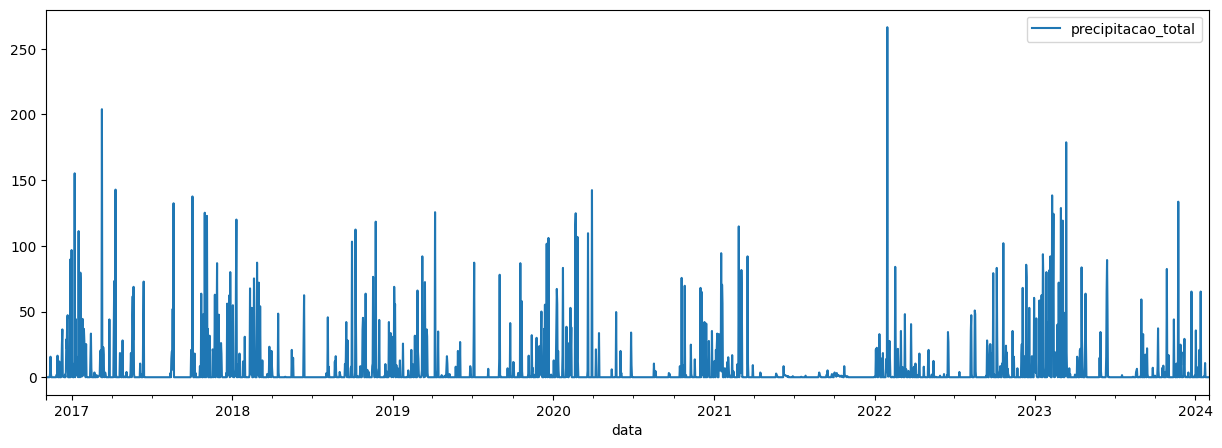

In [7]:
aux4.plot(y='precipitacao_total', figsize=(15, 5));

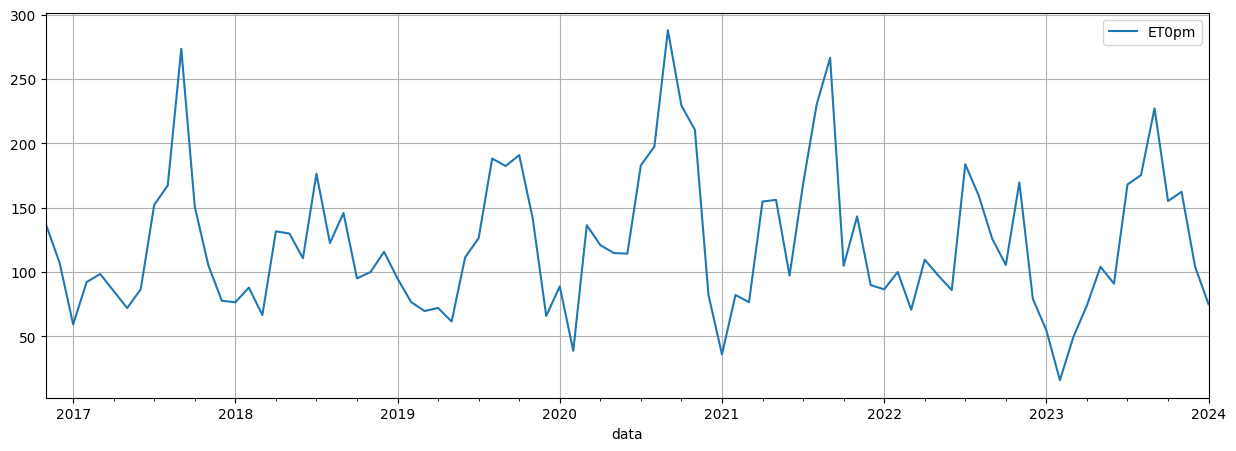

In [8]:
aux5 = aux4.groupby(['ano', 'mes']).agg({'temperatura_min': 'mean',
                                                     'temperatura_max': 'mean',
                                                     'temperatura_media': 'mean',
                                                     'umidade_rel': 'median',
                                                     'vento_velocidade': 'median',
                                                     'precipitacao_total': 'sum',
                                                     'ET0pm': 'sum'}).reset_index()

aux5['data'] = pd.to_datetime(aux5['ano'].astype(str) + '-' + aux5['mes'].astype(str))
aux5.set_index('data', inplace=True)
aux5.plot(y='ET0pm', figsize=(15, 5))
plt.grid(True);

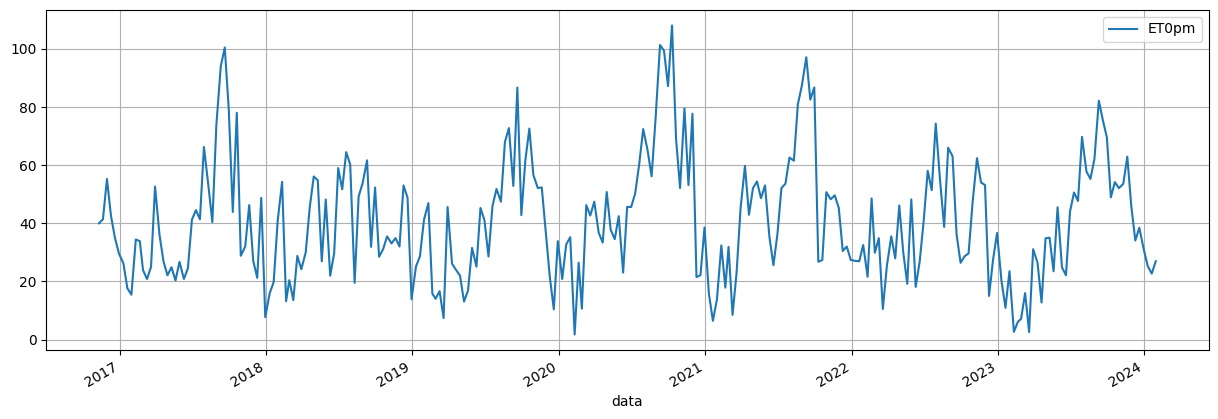

In [9]:
aux6 = aux4.groupby(['ano', 'mes', 'decendio']).agg({'temperatura_min': 'mean',
                                                     'temperatura_max': 'mean',
                                                     'temperatura_media': 'mean',
                                                     'umidade_rel': 'median',
                                                     'vento_velocidade': 'median',
                                                     'precipitacao_total': 'sum',
                                                     'ET0pm': 'sum'}).reset_index()

aux6['dia'] = np.where(aux6['mes'] == 2, np.where(aux6['decendio'] == 3, 28, aux6['decendio'] * 10), aux6['decendio'] * 10)
aux6['data'] = pd.to_datetime(aux6['ano'].astype(str) + '-' + aux6['mes'].astype(str) + '-' + aux6['dia'].astype(str))
aux6.set_index('data', inplace=True)
aux6.plot(y='ET0pm', figsize=(15, 5));
plt.grid(True)

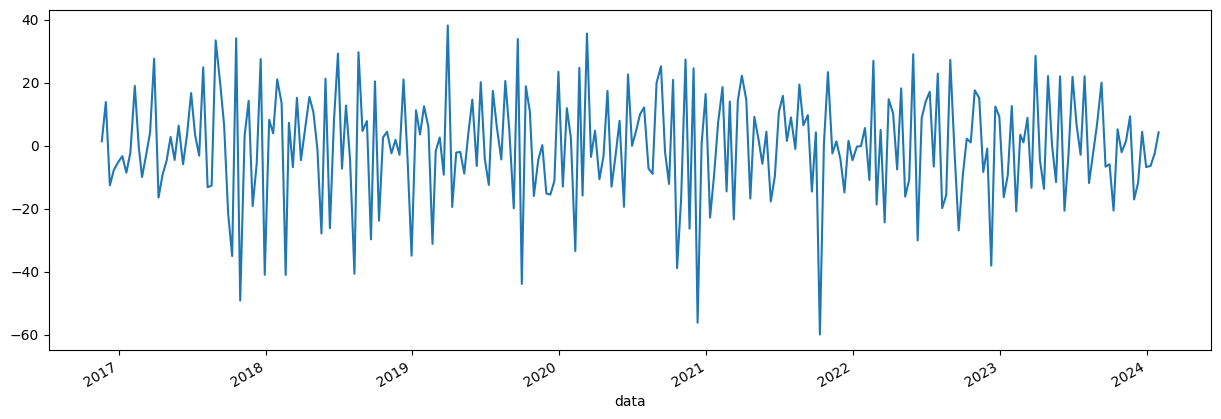

In [10]:
aux6['ET0pm'].diff(periods=1).dropna().plot(figsize=(15, 5));

<Figure size 1200x400 with 0 Axes>

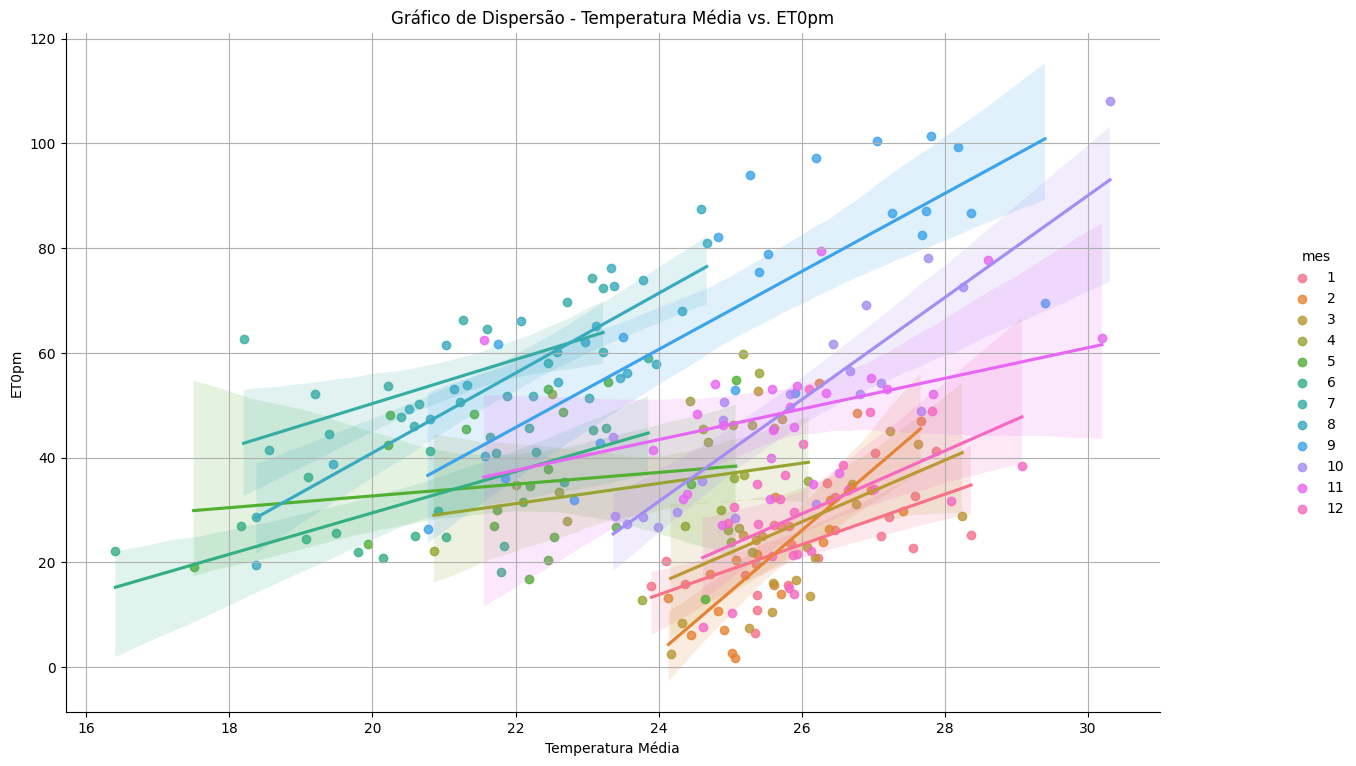

In [11]:
#Grafico de dispersão entre temperatura_media e ET0pm, com os pontos coloridos por estacao
import seaborn as sns

aux6['estacao'] = aux6.apply(lambda row: determinar_estacao(row['dia'], row['mes']), axis=1)
palette = {'Primavera': 'green', 'Verão': 'red', 'Inverno': 'blue', 'Outono': 'orange'}

plt.figure(figsize=(12, 4))
# Plotando o gráfico de dispersão usando Seaborn
g=sns.lmplot(data=aux6, x='temperatura_media', y='ET0pm', hue='mes')
g.fig.set_size_inches(15,8)
plt.title('Gráfico de Dispersão - Temperatura Média vs. ET0pm')
plt.xlabel('Temperatura Média')
plt.ylabel('ET0pm')
plt.grid(True)
plt.show()

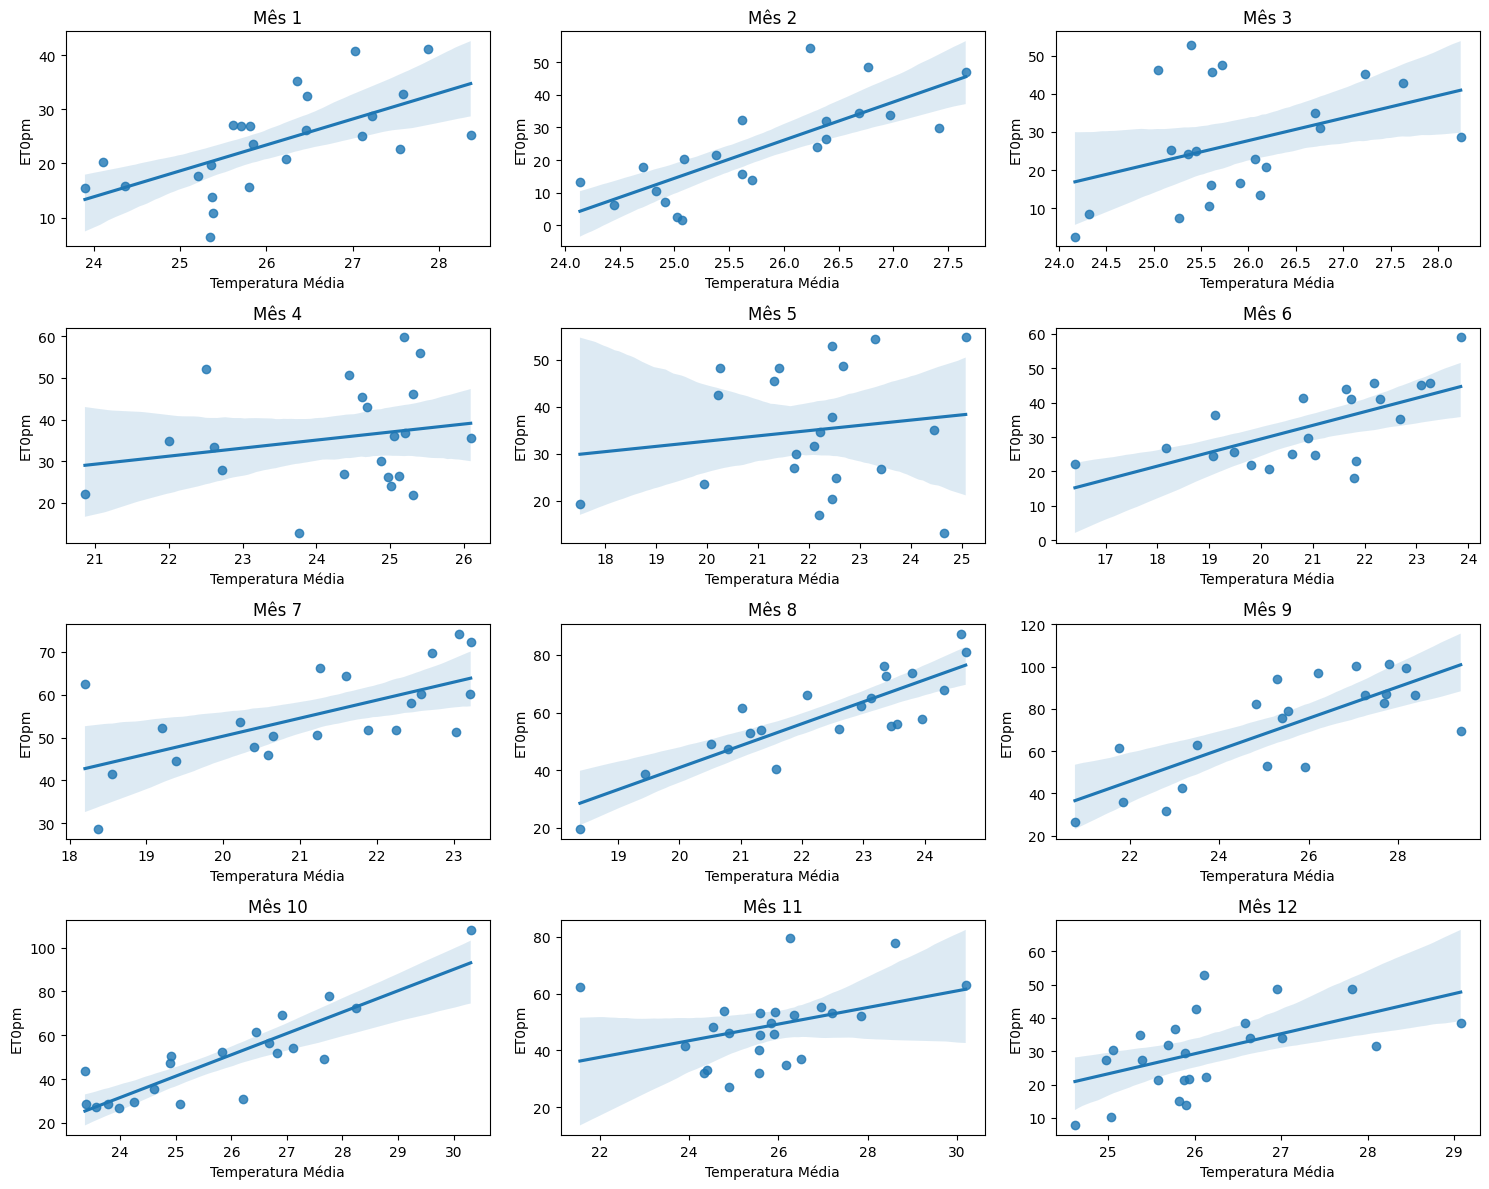

In [12]:
# Criando uma matriz de subplots 4x3
fig, axes = plt.subplots(4, 3, figsize=(15, 12))

# Iterando sobre os meses e criando os gráficos de dispersão com linhas de regressão
for mes in range(1, 13):
    row = (mes - 1) // 3
    col = (mes - 1) % 3
    ax = axes[row, col]
    
    # Filtrando o DataFrame para o mês atual
    df_mes = aux6[aux6['mes'] == mes]
    
    # Plotando o gráfico de dispersão com linha de regressão
    sns.regplot(data=df_mes, x='temperatura_media', y='ET0pm', ax=ax)
    
    # Configurações do subplot
    ax.set_title(f'Mês {mes}')
    ax.set_xlabel('Temperatura Média')
    ax.set_ylabel('ET0pm')

# Ajustando o layout
plt.tight_layout()
plt.show()

## Predição de evapotranspiração

In [13]:
aux6['estacao'] = aux6.apply(lambda row: determinar_estacao(row['dia'], row['mes']), axis=1)

In [14]:
aux7 = aux6.copy()
aux7['precipitacao_lag'] = aux7['precipitacao_total'].diff(periods=1).fillna(0)
aux7['temperatura_media_lag'] = aux7['temperatura_media'].diff(periods=10).fillna(0)
aux7['umidade_rel_lag'] = aux7['umidade_rel'].diff(periods=10).fillna(0)
aux7['mes_cos'] = np.cos((aux7['mes'] * (2 * np.pi)) / 12)
aux7['mes_sin'] = np.sin((aux7['mes'] * (2 * np.pi)) / 12)
aux7['decendio_cos'] = np.cos((aux7['decendio'] * (2 * np.pi)) / 3)
aux7['decendio_sin'] = np.sin((aux7['decendio'] * (2 * np.pi)) / 3)
aux7['dia_cos'] = np.cos((aux7['dia'] * (2 * np.pi)) / 365)
aux7['dia_sin'] = np.sin((aux7['dia'] * (2 * np.pi)) / 365)

df_treino = aux7[aux7['ano'] < 2022]; df_treino = df_treino.drop(columns=['ano', 'mes', 'decendio', 'dia'])
df_teste = aux7[aux7['ano'] == 2022]; df_teste = df_teste.drop(columns=['ano', 'mes', 'decendio', 'dia'])
df_validacao = aux7[aux7['ano'] == 2023]; df_validacao = df_validacao.drop(columns=['ano', 'mes', 'decendio', 'dia'])



In [15]:
hyperparameters = {
    'boosting_type': 'gbdt',
    'class_weight': None,
    'colsample_bytree': 1.0,
    'importance_type': 'split',
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'n_estimators': 100,
    'n_jobs': -1,
    'num_leaves': 5,
    'objective': None,
    'random_state': 123,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'subsample': 1.0,
    'subsample_for_bin': 200000,
    'subsample_freq': 0
}

minmax_columns = ['temperatura_min', 'temperatura_max', 'temperatura_media', 'umidade_rel', 'vento_velocidade', 'precipitacao_total', 'temperatura_media_lag', 'umidade_rel_lag', 'precipitacao_lag']
onehot_columns = ['estacao']

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), minmax_columns),
        ('onehot', OneHotEncoder(), onehot_columns)
    ], remainder='passthrough') 

pipeline = Pipeline([('preprocessor', preprocessor),
                     ('regressor', lgb.LGBMRegressor(**hyperparameters))])

pipeline.fit(df_treino.drop(columns=['ET0pm']), df_treino['ET0pm'])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 545
[LightGBM] [Info] Number of data points in the train set: 186, number of used features: 19
[LightGBM] [Info] Start training from score 42.018915


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmax', MinMaxScaler(),
                                                  ['temperatura_min',
                                                   'temperatura_max',
                                                   'temperatura_media',
                                                   'umidade_rel',
                                                   'vento_velocidade',
                                                   'precipitacao_total',
                                                   'temperatura_media_lag',
                                                   'umidade_rel_lag',
                                                   'precipitacao_lag']),
                                                 ('onehot', OneHotEncoder(),
                                                  ['estacao'])])),
                ('regressor',
                 LGBMRegressor(n_jobs=-1, num_leaves=5, random_state=123))])

In [16]:
# Acessar importância das features
feature_importances = pipeline.named_steps['regressor'].feature_importances_

features_originais = pipeline.named_steps['preprocessor'].get_feature_names_out()
feature_importances = pipeline.named_steps['regressor'].feature_importances_

# dicionário que associa o nome da feature à sua importância
feature_importances_dict = dict(zip(features_originais, feature_importances))

#Cria um dataframe para a importancia das features
df_feature_importances = pd.DataFrame(list(feature_importances_dict.items()), columns=['Feature', 'Importance'])

#Ordena a importancia das features em ordem decrescente
df_feature_importances.sort_values(by=['Importance'], ascending=False).reset_index(drop=True)

,Feature,Importance
0,minmax__umidade_rel,90
1,minmax__temperatura_media_lag,52
2,minmax__vento_velocidade,38
3,minmax__temperatura_min,32
4,minmax__umidade_rel_lag,32
5,minmax__precipitacao_total,30
6,minmax__temperatura_max,27
7,minmax__precipitacao_lag,26
8,minmax__temperatura_media,14
9,remainder__mes_sin,13


In [17]:
predictions_treino = pipeline.predict(df_treino.drop(columns=['ET0pm']))
ml_error('LightGBM', df_treino['ET0pm'], predictions_treino)

,Model Name,MAE,MAPE,RMSE,R2
0,LightGBM,2.059486,0.080816,2.75822,0.983369


In [18]:
predictions_teste = pipeline.predict(df_teste.drop(columns=['ET0pm']))
ml_error('LightGBM', df_teste['ET0pm'], predictions_teste)

,Model Name,MAE,MAPE,RMSE,R2
0,LightGBM,3.872526,0.121883,4.743782,0.905259


In [19]:
predictions_validacao = pipeline.predict(df_validacao.drop(columns=['ET0pm']))
ml_error('LightGBM', df_validacao['ET0pm'], predictions_validacao)

,Model Name,MAE,MAPE,RMSE,R2
0,LightGBM,4.299939,0.309369,5.634246,0.929502


## Distribuição das estações

In [20]:
import folium

estacoes = df[['ESTAÇÃO', 'LATITUDE', 'LONGITUDE']].drop_duplicates().reset_index(drop=True)
estacoes['LATITUDE'] = estacoes['LATITUDE'].str.replace(',', '.').astype(float)
estacoes['LONGITUDE'] = estacoes['LONGITUDE'].str.replace(',', '.').astype(float)

coordenadas = list(zip(estacoes['LATITUDE'], estacoes['LONGITUDE']))

# Cria um mapa centrado em uma localização específica
mapa = folium.Map(location=[-24.716667	, -47.550000], zoom_start=7)  # O zoom_start define o nível de zoom inicial

# Adiciona marcadores para cada ponto
for coord in coordenadas:
    folium.Marker(location=coord).add_to(mapa)

# Exibe o mapa
mapa


## Trabalhando com xarrays

In [21]:
import xarray